Metabarcoding Pipeline
======================

Frédéric Mahé, April 19th 2023

A fast and accurate metabarcoding pipeline.

Contrary to traditional pipelines, most filtering steps are done after
the clustering/denoising step, when the risk of eliminating real
molecular diversity is minimized.

Please feel free to ask questions at anytime during this hands-on
session.

Part 0: crash-course and set-up
-------------------------------

A quick introduction on the type of code you will see today.

### shell

#### code block

My pipeline is made of blocks of shell code:

``` shell
# variables
THREADS=4
ENCODING=33

# some comments
vsearch \
    --threads ${THREADS} \
    --fastq_mergepairs R1.fastq.gz \
    --reverse R2.fastq.gz \
    --fastq_ascii ${ENCODING} \
    --fastq_allowmergestagger \
    --quiet \
    --fastqout out.fastq
```

Some blocks can be executed in Google colab. Blocks that can’t be
executed are examples, like the one above. They are not necessary for
the pipeline.

#### redirect

You can redirect the output of a shell command:

``` shell
# basics
command > output.fastq
command 2> output.log
command 2> /dev/null
command < input.fastq

# but also
>>  2>>  2>&1  <(...)
```

Note: I’ve been writing shell scripts daily for nearly 20 years, and I
may use lesser known aspects of bash (and not know about recent
features). Feel free to ask or comment if my code is unclear.

#### wrap

A matter of personal preference:

``` bash
# too long to read:
vsearch --threads 4 --fastq_mergepairs R1.fastq.gz --reverse R2.fastq.gz --fastq_ascii 33 --fastq_allowmergestagger --quiet --fastqout out.fastq

# wrapping makes it more readable:
vsearch \
    --threads 4 \
    --fastq_mergepairs R1.fastq.gz \
    --reverse R2.fastq.gz \
    --fastq_ascii 33 \
    --fastq_allowmergestagger \
    --quiet \
    --fastqout out.fastq
```

#### pipe

make data flow! A remarkable asset of the Unix/Linux world:

``` bash
# slow
command1 input.fastq > tmp1.fastq
command2 tmp1.fastq > tmp2.fastq
command3 tmp2.fastq > final_output.fastq

# use pipes to avoid temporary files:
command1 input.fastq | \
    command2 | \
    command3 > final_output.fastq
```

Note: pipes were recently added to R, C++, and other languages.

#### tee

Use a `tee` to save an intermediary result:

``` bash
command1 input.fastq | \
    command2 | \
    tee output2.fastq | \
    command3 > final_output.fastq
```

A `tee` will duplicate your stream of data, allowing you to do process
it in two different ways simulatenously. It is possible to connect
multiple `tee`s and to create a multi-furcation.

#### test

The shell is a great tool to manipulate text. You can easily create fake
data and pass it to a software you would like to test:

``` bash
# create toy-examples:
printf ">s_1\nA\n"

# use them to test software behavior:
printf ">s_1\nA\n" | \
    swarm
```

Note: documentation rarely is 100% complete, when you have a doubt about
a tool, create a toy-example to test its behavior. We’ll dive deeper
into code testing this afternoon during the `lulu` session.

### FASTQ format

Metabarcoding data are usually available in
[FASTQ](https://en.wikipedia.org/wiki/FASTQ_format#Encoding) format:

-   most-frequent format,
-   human-readable,
-   encode quality values (probability of error for each position),
-   can be hard to parse,
-   encoding type must be guessed

<!-- -->

    @M05074:97:000000000-BPW9G:1:1101:10203:1383 1:N:0:2
    CATAATTTCCTCCGCTTATTGATATGCTTAAGTTCAGCGGGTATCCCTACCTGATCCGAGTTCAACCTAAGAAAGTTGGGGGTTCTGGCGGGTGGACGGCTGAACCCTGTAGCGACAAGTATTACTACGCTTAGAGCCAGACGGCACCGCCACTGCTTTTAAGTGCCGCCGGTACAGCGGGCCCCAAGGCCAAGCAGAGCTTGATTGGTCA
    +
    @-A-9EFGFFFFD7BFF7FE9,C9F<EFG99,CEF9,@77+@+CCC@F9FCF9,C@C,,+,8C9<CEF,,,,,,,CF,,+++8FEF9,?+++@+++B++@C+,,B?FE8E,,<+++++3C,CF9DF9>>CFE7,,3=@7,,@++@:FC7BC*CC:,7>DF9,,,,7?*=B*5?*:++7***=?EE3***2;***:*0*/;@C8*<C+*<<+

Note: the quality line may starts with a @ …

Note: Q values are a way to encode on one character numerical values
ranging from 0 to 41 (usually). These values represent the probability
of a wrong base calling for that particular position. Q20 means 1% of
risk, Q30 means 0.1%, and Q40 means 0.01%.

In paired-end sequencing, there are two files per sample: R1 and R2.
Each R1 read has a R2 counterpart, and reads are in the same order in
both files.

### Google Colab

Let’s explore this environment. This is our first executable block:

In [ ]:
%%shell

date
whoami

We are `root`! Maximal clearance level, we can do anything we want.

Check the OS version:

In [ ]:
%%shell

lsb_release -a
uname -a

The operating system is Ubuntu LTS 20.04. LTS stands for long-term
support, the most recent LTS at the time of writing is 22.04. Version
20.04 will be supported until April 2025.

Check basic utilities:

In [ ]:
%%shell

bash --version
git --version
gcc --version
python --version
R --version

`R`, `git` and the compilation toolchain are already installed.

The `gcc` version is a bit old (9.2), and might not allow to compile
code based on very recent standards (e.g.; `mumu` wich uses C++20
features).

What about hardware resources?

In [ ]:
%%shell

df -h
cat /proc/cpuinfo
cat /proc/meminfo

It seems that Google colab instances are virtual x86-64 machines with 2
CPU-cores (Intel Xeon @ 2.20GHz), 12 GB of RAM and 85 GB of storage
space.

I will assume that you also have [python](https://www.python.org/)
(version 3.7 or more), [R](https://cran.r-project.org/) (version 4.0 or
more), and [bash](https://www.gnu.org/software/bash/) (version 4 or
more).

Last check : is it possible to pass data from one `shell` code block to
another?

In [ ]:
%%shell

pwd
mkdir -p tmp
cd ./tmp/0
pwd
i=5
export j=5

In [ ]:
%%shell
pwd
echo "i="$i
echo "j="$j

It seems that in `%%shell` code blocks, `cd` moves, variable
declarations, and function declarations are limited to the current block
(no effect on downstream code blocks). Only file and folder creations
are persistent.

### install dependencies

Let’s create some folders:

In [ ]:
%%shell

mkdir -p src data images references results

We will need to install [vsearch](https://github.com/torognes/vsearch),
[cutadapt](https://github.com/marcelm/cutadapt/), and
[swarm](https://github.com/torognes/swarm).

Installing [lulu](https://github.com/tobiasgf/lulu) or
[mumu](https://github.com/frederic-mahe/mumu) is not necessary in this
particular pipeline.

#### install cutadapt

We could install the Ubuntu version:

In [ ]:
%%shell

apt update
apt search cutadapt

but it is a bit old. Let’s install `cutadapt` with `pip`:

In [ ]:
%%shell

python3 -m pip install --upgrade pip
python3 -m pip install --upgrade cutadapt

check:

In [ ]:
%%shell

cutadapt --version

#### install swarm

We could install `swarm` and `vsearch` using `conda`, but for
educational purposes, let’s compile them ourselves. We will put their
source code in the `/tmp` folder (this folder is cleaned automatically
between reboots):

In [ ]:
%%shell

cd /tmp/
git clone https://github.com/torognes/swarm.git
cd ./swarm/
make --jobs
make install

check:

In [ ]:
%%shell

swarm --version

clean-up:

In [ ]:
%%shell

rm --recursive /tmp/swarm/

#### install vsearch

In [ ]:
%%shell

cd /tmp/
git clone https://github.com/torognes/vsearch.git
cd ./vsearch/
./autogen.sh
./configure CFLAGS="-O3" CXXFLAGS="-O3"
make --jobs


check:

In [ ]:
%%shell

vsearch --version

clean-up:

In [ ]:
%%shell

rm --recursive /tmp/vsearch/

#### install python scripts

In the second part of the pipeline, we are going to use four python
scripts to build and update occurrence tables, and to compute
last-common ancestor taxonomic assignments.

The scripts are available on GitHub, let’s download the latest versions:

In [ ]:
%%shell

cd ./src/

# occurrence table creation
URL="https://raw.githubusercontent.com/frederic-mahe/fred-metabarcoding-pipeline/master/src"
for SCRIPT in "OTU_cleaver" "OTU_contingency_table_filtered" "OTU_table_updater" ; do
    wget --continue "${URL}/${SCRIPT}.py"
done

# taxonomic assignment
URL="https://raw.githubusercontent.com/frederic-mahe/stampa/master"
wget --continue "${URL}/stampa_merge.py"

#### collect figures

In [ ]:
%%shell

cd ./images/

# occurrence table creation
URL="https://raw.githubusercontent.com/frederic-mahe/fred-metabarcoding-pipeline/master/src"
for SCRIPT in "OTU_cleaver" "OTU_contingency_table_filtered" "OTU_table_updater" ; do
    wget --continue "${URL}/${SCRIPT}.py"
done

# taxonomic assignment
URL="https://raw.githubusercontent.com/frederic-mahe/stampa/master"
wget --continue "${URL}/stampa_merge.py"

### sequencing data

Today, we are going to use a subset of the Neotropical Forest Soil
dataset
([PRJNA317860](https://www.ebi.ac.uk/ena/browser/view/PRJNA317860);
[Mahé et al., 2017](https://doi.org/10.1038/s41559-017-0091)),
corresponding to the following ENA/SRA run accessions:

| runs        | sample |
|-------------|--------|
| SRR23272700 | B070   |
| SRR23272716 | B030   |
| SRR23272737 | B100   |
| SRR23272741 | B060   |
| SRR23272752 | B050   |
| SRR23272767 | L040   |
| SRR23272778 | L030   |
| SRR23272788 | B090   |
| SRR23272799 | B080   |
| SRR23272803 | B040   |
| SRR23272822 | L080   |
| SRR23272833 | L070   |
| SRR23272848 | L020   |
| SRR23272859 | L010   |
| SRR23272860 | B020   |
| SRR23272861 | B010   |
| SRR23272874 | L090   |
| SRR23272881 | L100   |
| SRR23272890 | L060   |
| SRR23272901 | L050   |

and subsampled at 1%, using `vsearch`:

``` shell
function subsample() {
    local -ri SEED=1
    local -r PERCENTAGE="1.0"
    local -r SUBSAMPLED_FASTQ="$(sed 's/NG-7070_// ; s/_lib.*_1976//' <<< ${1})"

    vsearch \
        --fastx_subsample "${1}" \
        --randseed "${SEED}" \
        --sample_pct "${PERCENTAGE}" \
        --quiet \
        --fastqout - | \
        gzip - > "${SUBSAMPLED_FASTQ}"
}


export -f subsample

find . -name "NG-7070_*.fastq.gz" -type f -exec bash -c 'subsample "$0"' {} \;
```

Subsampling is useful when you are developping and testing a new
pipeline. The dataset is smaller but remains realistic, allowing for a
faster developement cycle. With `vsearch`, you can also subsample down
to a particular number of reads.

Combining `vsearch` with the command `find` offers a very powerful and
robust way to find and subsample all fastq files (it will find every
file, including files in sub-folders). You might find a loop-based
approach easier to read:

``` shell
for FASTQ in "NG-7070_*.fastq.gz" ; do
    subsample "${FASTQ}"
done
```

Note: in a pair of R1 and R2 fastq files, both files have the same
number of reads, so using a fix seed (i.e., not zero) guarantees that
subsamplings results for both R1 and R2 fastq files are identical (same
number of reads, same reads, in the same order)

These 20 runs represent 4 GB of compressed data. To save time and
energy, we are going to download the subsampled files directly (roughly
40 MB in total). The files are hosted on my GitHub account:

In [ ]:
%%shell

cd ./data/

URL="https://github.com/frederic-mahe/BIO9905MERG1_vsearch_swarm_pipeline/raw/main/data"

wget "${URL}/MD5SUM"
for SAMPLE in B010 B020 B030 B040 B050 B060 B070 B080 B090 B100 L010 L020 L030 L040 L050 L060 L070 L080 L090 L100 ; do
    for READ in 1 2 ; do
        wget --continue "${URL}/${SAMPLE}_1_${READ}.fastq.gz"
    done
done

check:

In [ ]:
%%shell

cd ./data/
md5sum -c MD5SUM

Initial situation: fastq files are already demultiplexed, we have a pair
of R1 and R2 files for each sample.

Part 1: from fastq files to fasta files
---------------------------------------

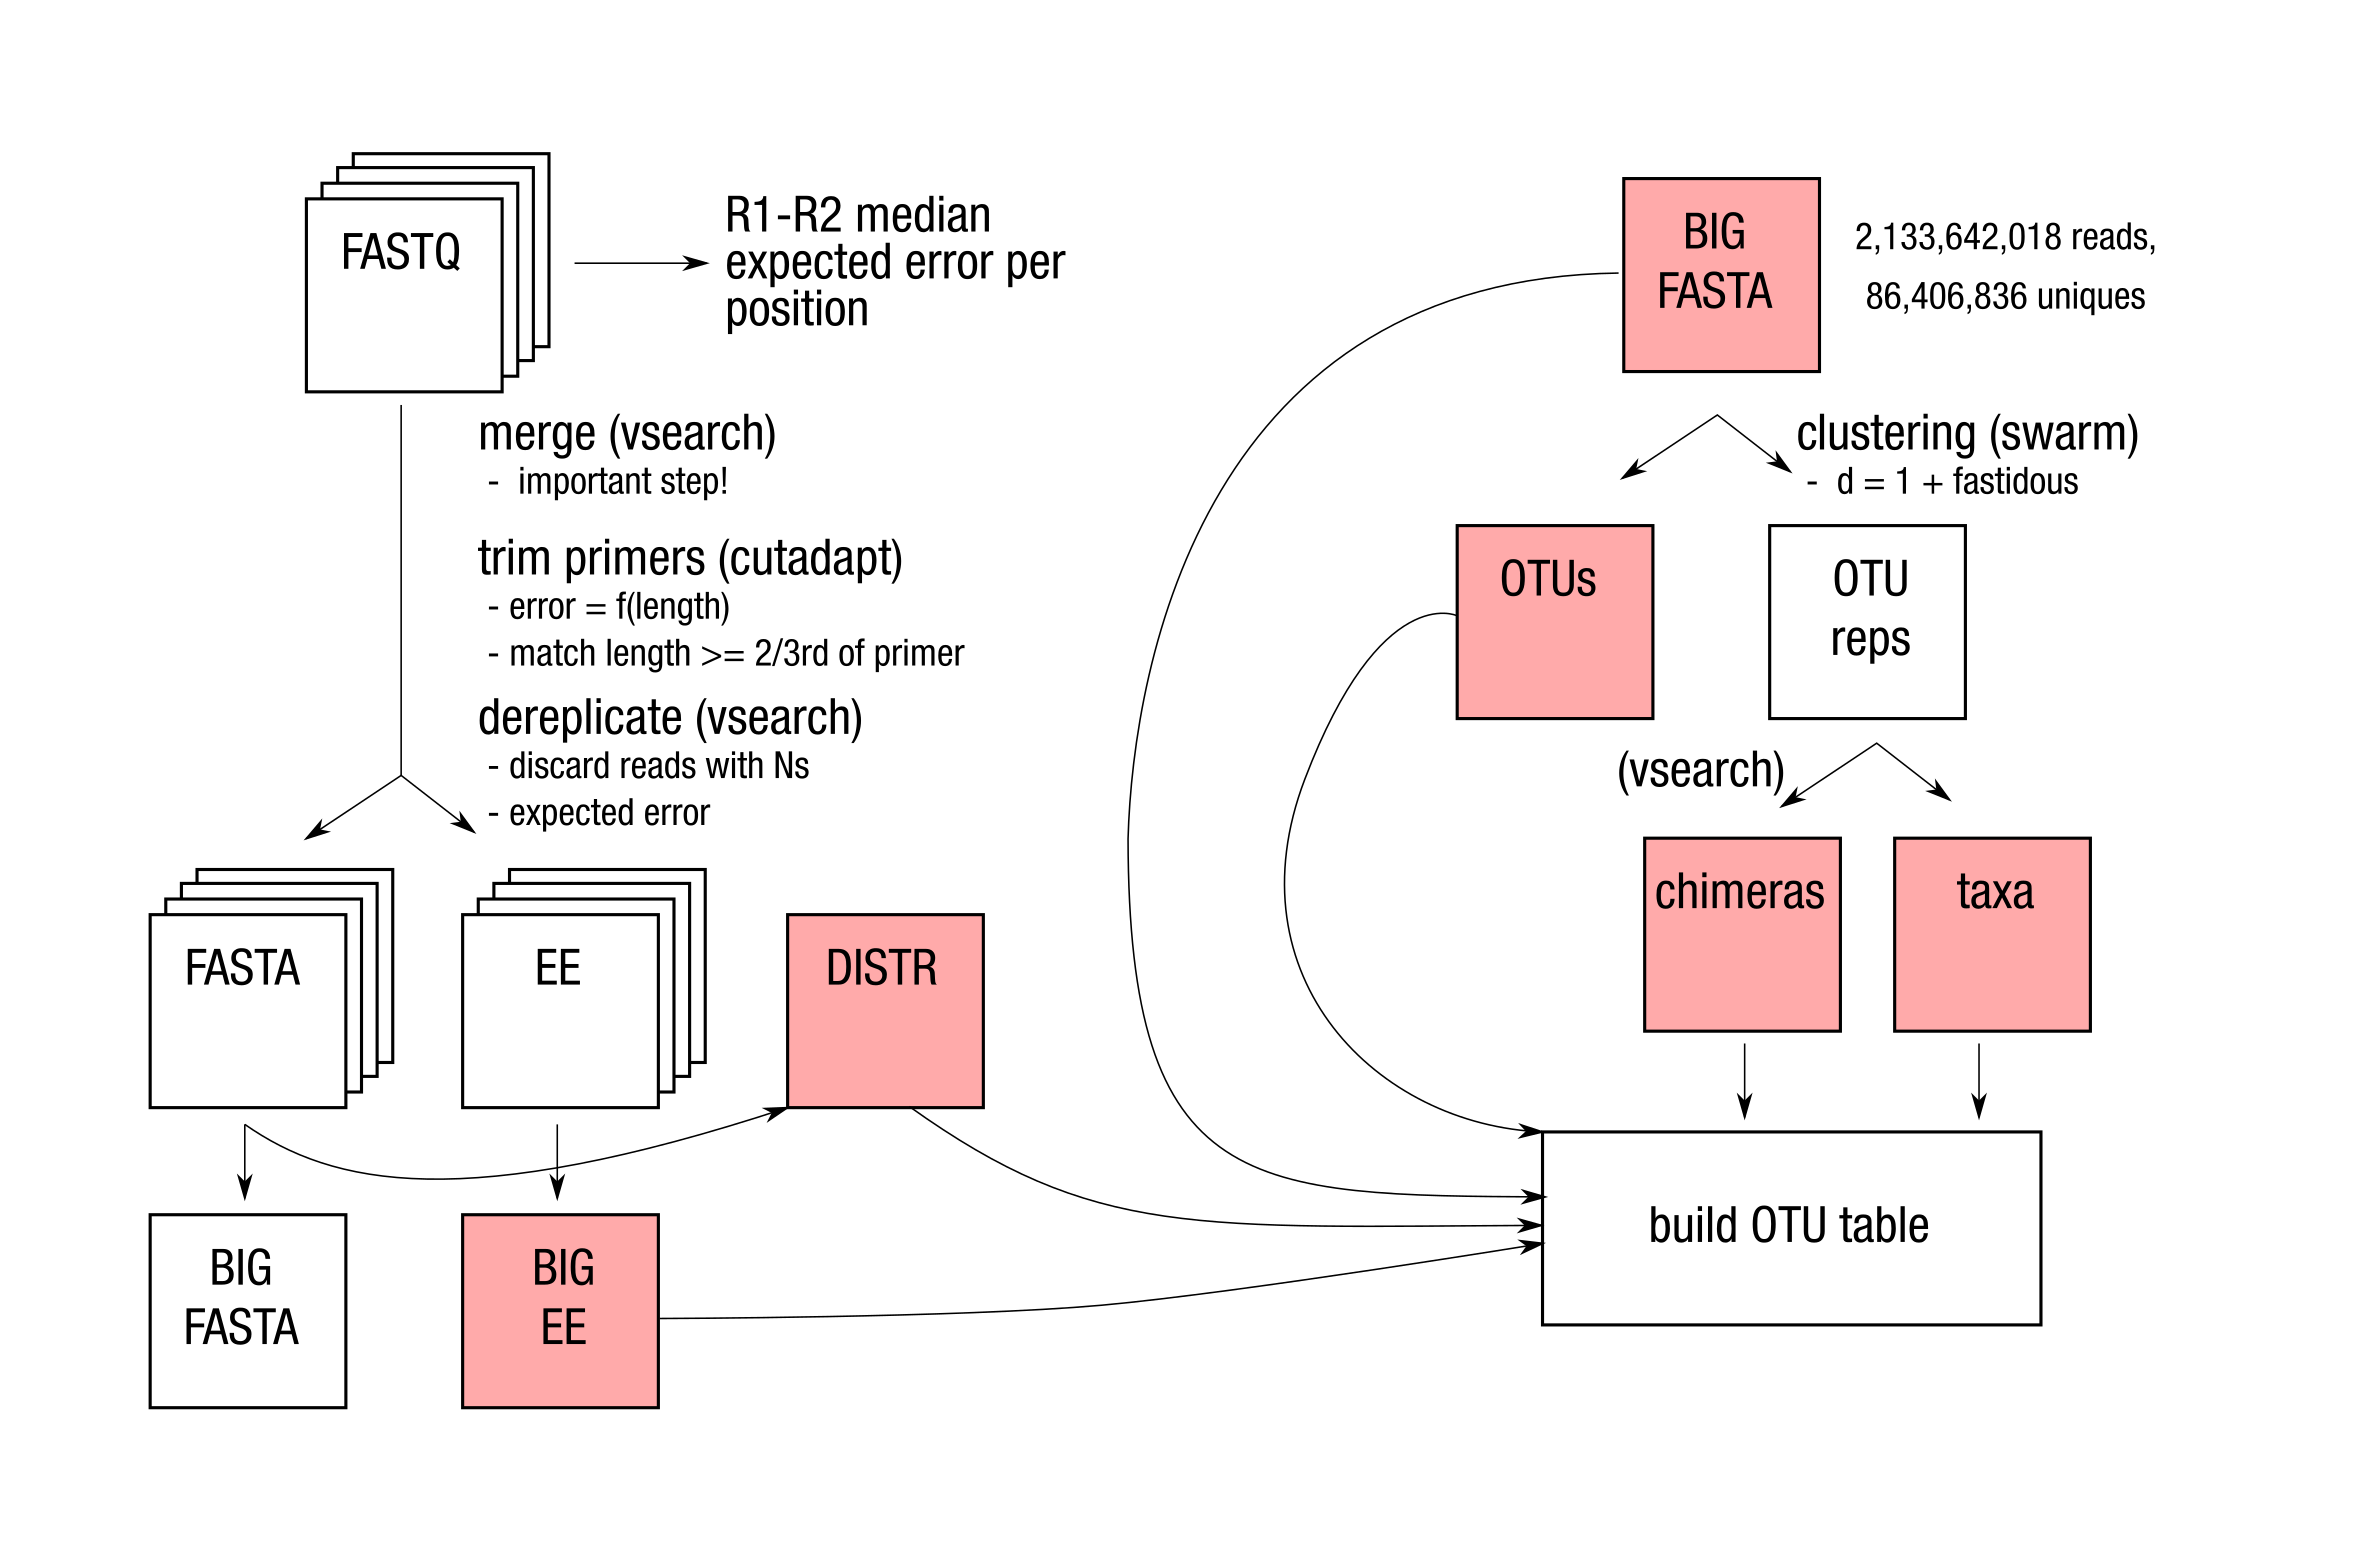

The pipeline is divided into two parts. A first part where each sample
is processed individually. And a second part where all samples are
pooled to produce an occurrence table.

In this first part of the pipeline, we will: 1. merge R1 and R2, 1. trim
primers, 1. convert fastq to fasta, 1. extract expected errors (for a
later *quality-based filtering*), 1. dereplicate fasta, 1. per-sample
clustering (for a later *cluster cleaving*)

The code below uses named pipes (`fifo`) to avoid writing intermediate
results to mass storage. The goal is to speed up processing, and to make
the code more modular and clearer. On the other hand, `fifo`s are tricky
to use, as you must remember to launch producers and consumers in the
backgroup before running the last consumer.

Don’t panic! While the script is running, we are going to look at each
function and explain what it does:

In [ ]:
%%shell

cd ./data/
export LC_ALL=C

## ------------------------------------------------------------ define variables
declare -r PRIMER_F="CCAGCASCYGCGGTAATTCC"
declare -r PRIMER_R="ACTTTCGTTCTTGATYRA"
declare -r FASTQ_NAME_PATTERN="*_1.fastq.gz"
declare -ri THREADS=2
declare -r CUTADAPT_OPTIONS="--minimum-length 32 --cores=${THREADS} --discard-untrimmed"
declare -r CUTADAPT="$(which cutadapt) ${CUTADAPT_OPTIONS}"  # cutadapt 4.1 or more recent
declare -r SWARM="$(which swarm)"  # swarm 3.0 or more recent
declare -r VSEARCH="$(which vsearch) --quiet"  # vsearch 2.21.1 or more recent
declare -ri ENCODING=33
declare -r MIN_F=$(( ${#PRIMER_F} * 2 / 3 ))  # match is >= 2/3 of primer length
declare -r MIN_R=$(( ${#PRIMER_R} * 2 / 3 ))
declare -r FIFOS=$(echo fifo_{merged,trimmed}_fastq fifo_filtered_fasta{,_bis})
declare -i TICKER=0

## ------------------------------------------------------------------- functions
revcomp() {
    # reverse-complement a DNA/RNA IUPAC string
    [[ -z "${1}" ]] && { echo "error: empty string" ; exit 1 ; }
    local -r nucleotides="acgturykmbdhvswACGTURYKMBDHVSW"
    local -r complements="tgcaayrmkvhdbswTGCAAYRMKVHDBSW"
    tr "${nucleotides}" "${complements}" <<< "${1}" | rev
}

merge_fastq_pair() {
    ${VSEARCH} \
        --threads "${THREADS}" \
        --fastq_mergepairs "${FORWARD}" \
        --reverse "${REVERSE}" \
        --fastq_ascii "${ENCODING}" \
        --fastq_allowmergestagger \
        --fastqout fifo_merged_fastq 2> "${SAMPLE}.log" &
}

trim_primers() {
    # search forward primer in both normal and revcomp: now all reads
    # are in the same orientation
    ${CUTADAPT} \
        --revcomp \
        --front "${PRIMER_F};rightmost" \
        --overlap "${MIN_F}" fifo_merged_fastq 2>> "${SAMPLE}.log" | \
        ${CUTADAPT} \
            --adapter "${ANTI_PRIMER_R}" \
            --overlap "${MIN_R}" \
            --max-n 0 - > fifo_trimmed_fastq 2>> "${SAMPLE}.log" &
}

convert_fastq_to_fasta() {
    # use SHA1 values as sequence names,
    # compute expected error values (ee)
    ${VSEARCH} \
        --fastq_filter fifo_trimmed_fastq \
        --relabel_sha1 \
        --fastq_ascii "${ENCODING}" \
        --eeout \
        --fasta_width 0 \
        --fastaout - 2>> "${SAMPLE}.log" | \
        tee fifo_filtered_fasta_bis > fifo_filtered_fasta &
}

extract_expected_error_values() {
    # extract ee for future quality filtering (keep the lowest
    # observed expected error value for each unique sequence)
    local -ri length_of_sequence_IDs=40
    paste - - < fifo_filtered_fasta_bis | \
        awk 'BEGIN {FS = "[>;=\t]"} {print $2, $4, length($NF)}' | \
        sort --key=3,3n --key=1,1d --key=2,2n | \
        uniq --check-chars=${length_of_sequence_IDs} > "${SAMPLE}.qual" &
}

dereplicate_fasta() {
    # dereplicate and discard expected error values (ee)
    ${VSEARCH} \
        --derep_fulllength fifo_filtered_fasta \
        --sizeout \
        --fasta_width 0 \
        --xee \
        --output "${SAMPLE}.fas" 2>> "${SAMPLE}.log"
}

list_local_clusters() {
    # retain only clusters with more than 2 reads
    # (do not use the fastidious option here)
    ${SWARM} \
        --threads "${THREADS}" \
        --differences 1 \
        --usearch-abundance \
        --log /dev/null \
        --output-file /dev/null \
        --statistics-file - \
        "${SAMPLE}.fas" | \
        awk 'BEGIN {FS = OFS = "\t"} $2 > 2' > "${SAMPLE}.stats"
}

## ------------------------------------------------------------------------ main
# from raw fastq files to ready-to-use sample files
declare -r ANTI_PRIMER_R="$(revcomp "${PRIMER_R}")"
find . -name "${FASTQ_NAME_PATTERN}" -type f -print0 | \
    while IFS= read -r -d '' FORWARD ; do
        TICKER=$(( $TICKER + 1 ))
        echo -e "${TICKER}\t${FORWARD}"
        REVERSE="${FORWARD/_1\./_2.}"  # adapt to fastq name patterns
        SAMPLE="${FORWARD/_1_1.*/}"

        # clean (remove older files, if any)
        rm --force "${SAMPLE}".{fas,qual,log,stats} ${FIFOS}
        mkfifo ${FIFOS}

        merge_fastq_pair
        trim_primers
        convert_fastq_to_fasta
        extract_expected_error_values
        dereplicate_fasta
        list_local_clusters

        # clean (make sure fifos are not reused)
        rm ${FIFOS}
        unset FORWARD REVERSE SAMPLE
    done

To adapt this code to another dataset, you just need to change the
primer sequences in the initial block of variables, and the raw fastq
file search pattern and sample file naming (in the final `while` loop),
if your raw fastq files follow another naming rule.

### variable declarations

``` shell
VAR1="some text"
declare -r VAR1="more text"
declare -ri VAR2=42
```

Here, we are using `declare -r` to indicate that `VAR1` is a constant.
If we try to modify it somewhere in the code, that’s a bug, and the
execution will stop with an error message.

`declare -ri` indicates that `VAR2` is a constant integer.

### R1 and R2 merging

``` shell
merge_fastq_pair() {
    ${VSEARCH} \
        --threads "${THREADS}" \
        --fastq_mergepairs "${FORWARD}" \
        --reverse "${REVERSE}" \
        --fastq_ascii "${ENCODING}" \
        --fastq_allowmergestagger \
        --fastqout fifo_merged_fastq 2> "${SAMPLE}.log" &
}
```

before merging:

    R1: ADAPTOR-TAG-PRIMER_FORWARD-actual_target_sequen
                                                   ||||
                                                   quence-ESREVER_REMIRP-GAT-ROTPADA :R2

after merging:

    ADAPTOR-TAG-PRIMER_FORWARD-actual_target_sequence-ESREVER_REMIRP-GAT-ROTPADA

A minimal overlap and similarity is required for the merging. Reads that
can’t be merged are discarded. `vsearch` re-computes the quality values
of the overlaping positions. An overlap corresponds to a double
observation, and the error probability must then be re-evaluated for
each position in the overlap. Some mergers do it the wrong way.

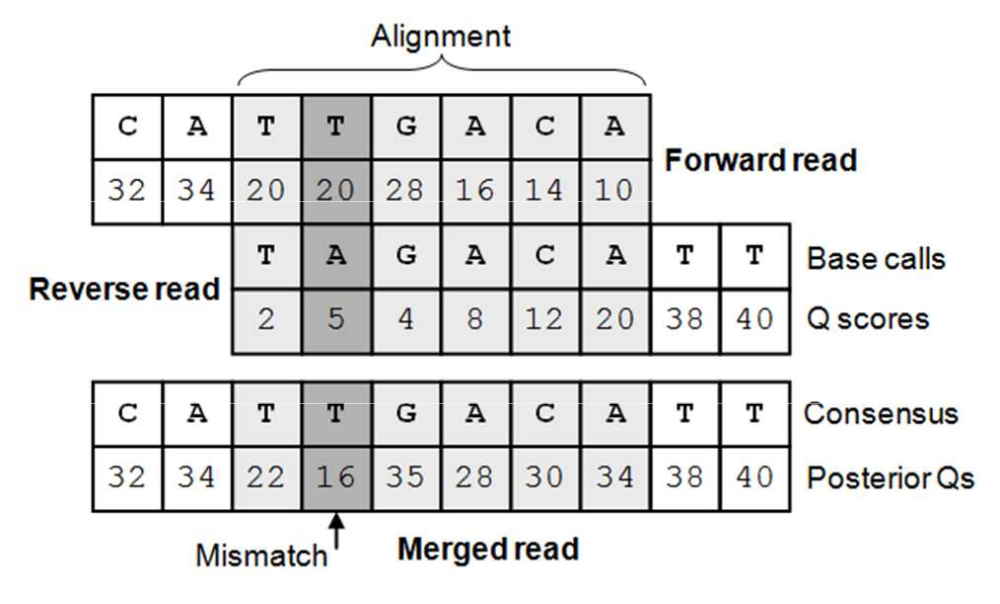

Note: according to [Edgar and Flyvberg
(2015)](https://doi.org/10.1093/bioinformatics/btv401) merging is an
important step that can change radically the apparent diversity profile
of a community (some popular mergers do not cope well with variable
length markers).

### reverse-complement

``` shell
revcomp() {
    # reverse-complement a DNA/RNA IUPAC string
    [[ -z "${1}" ]] && { echo "error: empty string" ; exit 1 ; }
    local -r nucleotides="acgturykmbdhvswACGTURYKMBDHVSW"
    local -r complements="tgcaayrmkvhdbswTGCAAYRMKVHDBSW"
    tr "${nucleotides}" "${complements}" <<< "${1}" | rev
}
```

That function takes a primer sequence, for example `ACTTTCGTTCTTGATYRA`
and outputs the reverse-complement of that sequence
(`TYRATCAAGAACGAAAGT`). This is useful when searching for primers after
merging, because the reverse primer is reverse-complemented in merged
reads:

    ADAPTOR-TAG-PRIMER_FORWARD-actual_target_sequence-ESREVER_REMIRP-GAT-ROTPADA

### trim primers

After merging, we use cutadapt to trim primers:

``` shell
trim_primers() {
    # search forward primer in both normal and revcomp: now all reads
    # are in the same orientation
    ${CUTADAPT} \
        --revcomp \
        --front "${PRIMER_F};rightmost" \
        --overlap "${MIN_F}" fifo_merged_fastq 2>> "${SAMPLE}.log" | \
        ${CUTADAPT} \
            --adapter "${ANTI_PRIMER_R}" \
            --overlap "${MIN_R}" \
            --max-n 0 - > fifo_trimmed_fastq 2>> "${SAMPLE}.log" &
}
```

Before:

    ADAPTOR-TAG-PRIMER_FORWARD-actual_target_sequence-ESREVER_REMIRP-GAT-ROTPADA

the first call removes the *rightmost* forward primer (and everything
before):

    actual_target_sequence-ESREVER_REMIRP-GAT-ROTPADA

the second call removes the reverse primer (and everything after).

    actual_target_sequence

At either step, if a primer is not found, the read is discarded.

`--revcomp`: some sequencing protocols can produce reads in random
orientations (R1 contains a mix of forward and reverse reads). That
option has the effect of re-orienting the reads.

`--overlap`: by default, cutadapt considers that an overlap of three
nucleotides is enough for a match. Here we require a minimal overlap
equal to 2/3rd of the length of our primers.

    Match:

       MER_FORWARD-actual_target_sequence-ESREVER_REMIRP-GAT-ROTPADA
       |||||||||||
    PRIMER_FORWARD


    No Match
              WARD-actual_target_sequence-ESREVER_REMIRP-GAT-ROTPADA
              ||||
    PRIMER_FORWARD

Note: with `--max-n 0`, reads with uncertain nucleotides (`N`) are
discarded.

### convert fastq to fasta

A simple format conversion:

``` shell
convert_fastq_to_fasta() {
    # use SHA1 values as sequence names,
    # compute expected error values (ee)
    ${VSEARCH} \
        --fastq_filter fifo_trimmed_fastq \
        --relabel_sha1 \
        --fastq_ascii "${ENCODING}" \
        --eeout \
        --fasta_width 0 \
        --fastaout - 2>> "${SAMPLE}.log" | \
        tee fifo_filtered_fasta_bis > fifo_filtered_fasta &
}
```

For example, a fastq entry such as:

    @s1
    AAAA
    +
    IIII

will be transformed into a `fasta` entry, with a sequence-derived name
(hash value of the sequence), and the computed expected error (later
used for quality filtering):

    >e2512172abf8cc9f67fdd49eb6cacf2df71bbad3;ee=0.0004000
    AAAA

Why using hash values as sequence names?

-   easy to compute,
-   compact fix length name,
-   readable (you get use to it),
-   a given sequence will always produce the same hash,
-   allows cross-studies comparisons

### extract expected error values

Extract and store read lengths and expected error values (later used for
quality filtering). If two reads have the exact same sequence, keep the
best (lowest) expected error.

``` shell
extract_expected_error_values() {
    # extract ee for future quality filtering (keep the lowest
    # observed expected error value for each unique sequence)
    local -ri length_of_sequence_IDs=40
    paste - - < fifo_filtered_fasta_bis | \
        awk 'BEGIN {FS = "[>;=\t]"} {print $2, $4, length($NF)}' | \
        sort --key=3,3n --key=1,1d --key=2,2n | \
        uniq --check-chars=${length_of_sequence_IDs} > "${SAMPLE}.qual" &
}
```

The result is a file with three columns: 1. amplicon name, 1. lowest
expected error observed for that amplicon in that sample, 1. amplicon
length

    17765e625e2e3588a21306012dfd8f162b8944b8 0.003813 48
    3dd5e4500bd663e4dd27bf0e2ae5b41cb9eee2b9 0.004051 51
    138408e37cf3c86e025cf6d5f6828eff9dbd1015 0.004448 56
    75f075940a92869137394c5a0b9d06d5c4aad2f6 0.5106 57
    1a8baf082848f50d2019ed162c22e87e02122868 0.004766 60
    3b6f64c93290cee1f1102065ddcb345355e0f223 0.005084 64
    d0b25e99d48fd996dedb179cefae6941c768abb5 0.005322 67
    319f8eb5171101539d3fb7255c3edd500ec5eb6b 0.005481 69
    28d992d5a8900d23be60dee0e07f27872a30f770 0.03710 70
    c7c55f0c514ce8c2a5ee49f02523dadcd96a4109 0.01171 78
    ...

Note: that function could be simplified now that `vsearch` version 2.23
can add length attributes `;length=123` to fastq and fasta headers.

### dereplicate

The first significant lossless reduction of our dataset! In
metabarcoding datasets, some sequences are rare and only observed once,
whereas some sequences are present in many exact copies. When coded
correctly, finding identical sequences is a very fast and efficient
operation:

``` shell
dereplicate_fasta() {
    # dereplicate and discard expected error values (ee)
    ${VSEARCH} \
        --derep_fulllength fifo_filtered_fasta \
        --sizeout \
        --fasta_width 0 \
        --xee \
        --output "${SAMPLE}.fas" 2>> "${SAMPLE}.log"
}
```

For instance, this fasta file:

    >e2512172abf8cc9f67fdd49eb6cacf2df71bbad3;ee=0.0004000
    AAAA
    >e2512172abf8cc9f67fdd49eb6cacf2df71bbad3;ee=0.0004000
    AAAA

will be dereplicated into this one:

    >e2512172abf8cc9f67fdd49eb6cacf2df71bbad3;size=2
    AAAA

Note that expected error values are removed by the `-xee` option, and
that a new attribute `;size=2` has been added to represent the fact that
this particular sequence has been observed twice.

### list local clusters

Later in this analysis, we will need to search for cluster co-occurences
on a per-sample basis. For each sample, we quickly generate clusters and
a list of cluster seeds with `swarm` and store the results. Here we use
`swarm` for the first time, I will give more details when `swarm` will
be used to process the whole dataset (pooled samples), in the second
part of the pipeline.

``` shell
list_local_clusters() {
    # retain only clusters with more than 2 reads
    # (do not use the fastidious option here)
    ${SWARM} \
        --threads "${THREADS}" \
        --differences 1 \
        --usearch-abundance \
        --log /dev/null \
        --output-file /dev/null \
        --statistics-file - \
        "${SAMPLE}.fas" | \
        awk 'BEGIN {FS = OFS = "\t"} $2 > 2' > "${SAMPLE}.stats"
}
```

Here, `swarm` reads a fasta file, representing a sample, and produces a
table looking like that:

| uniq | abundance | seed                                     | abundance | singletons | layers | steps |
|------|-----------|------------------------------------------|-----------|------------|--------|-------|
| 5897 | 22010     | 3db68d2f77252793f23d7089d0d4103eb8942dcb | 3612      | 4600       | 8      | 8     |
| 5528 | 15548     | 45211af6b7811bf45b5d3694054b800b5b13efd4 | 3728      | 4488       | 9      | 9     |
| 3058 | 13452     | 47e639615ad19c8dededae45f38beb52c4e9861d | 3542      | 2252       | 9      | 9     |
| 2172 | 8268      | 307ab3d7f513adc74854dd72e817fe02f7601db2 | 3722      | 1639       | 8      | 8     |
| 1453 | 6754      | e52a67c43758a5f9a39b4cb42ac10cf41958e1d4 | 3563      | 1053       | 4      | 4     |
| 1437 | 8836      | 962e2976f63ec09db8361ce4a498f50ade4b1674 | 3712      | 1046       | 4      | 4     |
| 1303 | 6307      | 79ae1f05f177ad948d18dc86a7944772c63273b9 | 3559      | 971        | 6      | 6     |
| 1126 | 6032      | b0835c4fba3d39e25059371902b0774741e3a57d | 3562      | 748        | 5      | 5     |
| 759  | 5355      | 91be8585fcad245e9f3a53578207c58355426583 | 3603      | 540        | 4      | 4     |
| 743  | 5981      | 42871cf2b4deaa78cbd1c163847567685c56d44e | 3654      | 567        | 4      | 4     |

In the second part of the pipeline, we are going to use that table as a
list of sequences that played the role of cluster seeds in this
particular sample. Don’t worry, that part will be explained in details.

### loop over each pair of fastq files

Finally, we search for all fastq R1 files (`find`) and we apply our
functions (merge, trim, convert, extract, dereplicate, clusterize). If
we remove the visual clutter, it looks like this:

``` shell
find . -name "${FASTQ_NAME_PATTERN}" -type f -print0 | \
    while IFS= read -r -d '' FORWARD ; do
        ...
        merge_fastq_pair
        trim_primers
        convert_fastq_to_fasta
        extract_expected_error_values
        dereplicate_fasta
        list_local_clusters
        ...
    done
```

That’s it for the first part of the pipeline!

The whole process is very fast, even for large datasets. It is also easy
to distribute the computation load on many machines, if need be.

### trimming and merging success rate?

Read merging and primer trimming are lossy filters (reads are lost). It
is a good practice to control the per-sample and overall yield:

In [ ]:
%%shell

cd ./data/

# format as a table
for f in *.log ; do
    echo -en "${f/\.log/}\t"
    awk '{if (NR == 1) {printf "%s\t", $1}
          if (NR == 2) {printf $1"\t"}}' ${f}
    grep "Reads with adapters" "${f}" | \
        awk '{printf $4"\t"}' | tr -d ","
      printf "\n"
  done

| samples | reads | assembled | F    | R    |
|---------|-------|-----------|------|------|
| B010    | 3359  | 2109      | 1928 | 1877 |
| B020    | 6987  | 4191      | 3721 | 3646 |
| B030    | 5130  | 3371      | 3089 | 2993 |
| B040    | 7158  | 4502      | 4033 | 3967 |
| B050    | 2903  | 1931      | 1716 | 1341 |
| B060    | 7494  | 4337      | 3716 | 3693 |
| B070    | 1034  | 720       | 611  | 418  |
| B080    | 8614  | 5703      | 5327 | 5225 |
| B090    | 9268  | 6005      | 5702 | 5630 |
| B100    | 11644 | 7301      | 6774 | 6740 |
| L010    | 6484  | 4101      | 3721 | 3588 |
| L020    | 3656  | 2392      | 2195 | 2065 |
| L030    | 3372  | 2084      | 1888 | 1766 |
| L040    | 7981  | 5127      | 4710 | 4654 |
| L050    | 8092  | 5377      | 5060 | 4996 |
| L060    | 7789  | 5167      | 4707 | 4616 |
| L070    | 7215  | 4777      | 4352 | 4292 |
| L080    | 3577  | 2207      | 1996 | 1917 |
| L090    | 7210  | 4291      | 3991 | 3914 |
| L100    | 8502  | 5470      | 4947 | 4872 |

A yield above 80% is good. Below 60%, something might be wrong with your
run or your biological material (bad chemistry, target sequence too
long, non-specific amplification, wrong primer sequences, etc.).

Part 1¾: taxonomic references
-----------------------------

Before tackling the second part of the pipeline, we need to prepare our
reference database that is going to be used for the taxonomic assignment
of our environmental sequences.

We are working with 18S V4 amplicons. We could use
[Silva](http://www.arb-silva.de/) SSU, but
[PR2](https://github.com/pr2database/pr2database), the Protist Ribosomal
Reference database, is a well-curated and eukaryote specific database of
SSU (18S) references. Let’s use the latest version (5.0), published
earlier this month:

In [ ]:
%%shell

cd ./references/

revcomp() {
    # reverse-complement a DNA/RNA IUPAC string
    [[ -z "${1}" ]] && { echo "error: empty string" ; exit 1 ; }
    local -r nucleotides="acgturykmbdhvswACGTURYKMBDHVSW"
    local -r complements="tgcaayrmkvhdbswTGCAAYRMKVHDBSW"
    tr "${nucleotides}" "${complements}" <<< "${1}" | rev
}

## download PR2 (UTAX version)
declare -r URL="https://github.com/pr2database/pr2database/releases/download"
declare -r VERSION="5.0.0"
declare -r SOURCE="pr2_version_${VERSION}_SSU_UTAX.fasta"
[[ -e "${SOURCE}.gz" ]] || wget "${URL}/v${VERSION}/${SOURCE}.gz"

## search for non-ASCII characters
zgrep --color='auto' -P -n '[^\x00-\x7F]' "${SOURCE}.gz"

## extract the V4 region (primers from Stoeck et al. 2010)
declare -r PRIMER_F="CCAGCASCYGCGGTAATTCC"
declare -r PRIMER_R="ACTTTCGTTCTTGATYRA"
declare -r ANTI_PRIMER_R="$(revcomp "${PRIMER_R}")"
declare -r OUTPUT="${SOURCE/_UTAX*/}_${PRIMER_F}_${PRIMER_R}.fas"
declare -r LOG="${OUTPUT/.fas/.log}"
declare -r MIN_LENGTH="32"
declare -r ERROR_RATE="0.2"
declare -r MIN_F=$(( ${#PRIMER_F} * 1 / 3 ))
declare -r MIN_R=$(( ${#PRIMER_R} * 1 / 3 ))
declare -r OPTIONS="--minimum-length ${MIN_LENGTH} --discard-untrimmed --error-rate ${ERROR_RATE}"
declare -r CUTADAPT="$(which cutadapt) ${OPTIONS}"

zcat "${SOURCE}.gz" | \
    dos2unix | \
    sed '/^>/ s/;tax=k:/ /
         /^>/ s/,[dpcofgs]:/|/g
         /^>/ ! s/U/T/g' | \
     ${CUTADAPT} \
         --revcomp \
         --front "${PRIMER_F}" \
         --overlap "${MIN_F}" - 2> "${LOG}" | \
         ${CUTADAPT} \
         --adapter "${ANTI_PRIMER_R}" \
         --overlap "${MIN_R}" - > "${OUTPUT}" 2>> "${LOG}"

I won’t go into details here, but you might notice some familiar code
such as `revcomp()` and two calls to `cutadapt`. The goal here is to
download and trim the reference sequences:

    reference 1: xxxxxxxx-PRIMER_F-target_region-PRIMER_R-xxxxx
    reference 2:            IMER_F-target_region-PRIMER_R-xxxxxxxxxxx
    reference 3:                    arget-region-PRIMER_R-xxxxxxxxxxxxxxxxxxxx

Discard references that do not contain our target region (flanked by our
primers), and trim the primers. The reference dataset is now much
smaller, and limited to our target region:

    reference 1:                   target_region
    reference 2:                   target_region

Note: while preparing this, I’ve found a small bug in the latest PR2
release ([weird character in one species
name](https://github.com/pr2database/pr2database/issues/37))

### subsample PR2

With a complete PR2 reference dataset, taxonomic assignment would take
more than an hour on a Google colab instance (that’s the most
computationaly intensive step in whole the pipeline). To speed up
things, I provide a PR2 subset with exactly what we need for the
Neotropical dataset.

In [ ]:
%%shell

cd ./references/

URL="https://github.com/frederic-mahe/BIO9905MERG1_vsearch_swarm_pipeline/raw/main/references"
LIST="useful_references.list"
TRIMMED_PR2="pr2_version_5.0.0_SSU_CCAGCASCYGCGGTAATTCC_ACTTTCGTTCTTGATYRA.fas"

wget --continue "${URL}/${LIST}"

grep \
    --no-group-separator \
    --after-context=1 \
    --fixed-strings \
    --file "${LIST}" \
    "${TRIMMED_PR2}" > "${TRIMMED_PR2/\.fas/_subset.fas}"

Part 2: from fasta files to an annotated occurrence table
---------------------------------------------------------

-   remove unused variables

In [ ]:
%%shell

cd ./results/
export LC_ALL=C

## ------------------------------------------------------------ define variables
declare -r PROJECT="Neotropical_soils_18S_V4"
declare -r DATA_FOLDER="../data/"
declare -r SWARM="$(which swarm)"  # swarm 3.0 or more recent
declare -r VSEARCH="$(which vsearch)"  # vsearch 2.21 or more recent
declare -ri THREADS=2
declare -ri RESOLUTION=1
declare -ri FILTER=2
declare -r SRC="../src"
declare -r OTU_CLEAVER="OTU_cleaver.py"
declare -r OTU_TABLE_BUILDER="OTU_contingency_table_filtered.py"
declare -r OTU_TABLE_UPDATER="OTU_table_updater.py"
declare -r STAMPA_MERGE="stampa_merge.py"
declare -r DATABASE="../references/pr2_version_5.0.0_SSU_CCAGCASCYGCGGTAATTCC_ACTTTCGTTCTTGATYRA_subset.fas"

N_SAMPLES=$(find "${DATA_FOLDER}" -name "*.fas" \
                -type f ! -empty -print0 | tr -d -c '\0' | wc -m)
FINAL_FASTA="${PROJECT}_${N_SAMPLES}_samples.fas"
QUALITY_FILE="${FINAL_FASTA%.*}.qual"
DISTRIBUTION_FILE="${FINAL_FASTA%.*}.distr"
POTENTIAL_SUB_SEEDS="${FINAL_FASTA%.*}_per_sample_OTUs.stats"
LOG="${FINAL_FASTA%.*}.log"
OUTPUT_SWARMS="${FINAL_FASTA%.*}_${RESOLUTION}f.swarms"
OUTPUT_LOG="${FINAL_FASTA%.*}_${RESOLUTION}f.log"
OUTPUT_STATS="${FINAL_FASTA%.*}_${RESOLUTION}f.stats"
OUTPUT_STRUCT="${FINAL_FASTA%.*}_${RESOLUTION}f.struct"
OUTPUT_REPRESENTATIVES="${FINAL_FASTA%.*}_${RESOLUTION}f_representatives.fas"
TAXONOMIC_ASSIGNMENTS="${OUTPUT_REPRESENTATIVES%.*}.results"
UCHIME_RESULTS="${OUTPUT_REPRESENTATIVES%.*}.uchime"
UCHIME_LOG="${OUTPUT_REPRESENTATIVES%.*}.log"
OTU_TABLE="${FINAL_FASTA%.*}.OTU.filtered.cleaved.table"


## ---------------------------------------------------------- global clustering
echo "run global clustering and chimera detection..."

## Build expected error file
find "${DATA_FOLDER}" -name "*.qual" \
    -type f ! -empty -print0 | \
    sort -k3,3n -k1,1d -k2,2n --merge --files0-from=- | \
    uniq --check-chars=40 > "${QUALITY_FILE}" &


## Build distribution file (sequence <-> sample relations)
find "${DATA_FOLDER}" -name "*.fas" \
    -type f ! -empty -execdir grep -H "^>" '{}' \; | \
    sed 's/.*\/// ; s/\.fas:>/\t/ ; s/;size=/\t/ ; s/;$//' | \
    awk 'BEGIN {FS = OFS = "\t"} {print $2, $1, $3}' > "${DISTRIBUTION_FILE}" &


## list all cluster seeds of size > 2
find "${DATA_FOLDER}" -name "*.stats" \
    -type f ! -empty -execdir grep -H "" '{}' \; | \
    sed 's/^\.\/// ; s/\.stats:/\t/' > "${POTENTIAL_SUB_SEEDS}" &


## global dereplication
find "${DATA_FOLDER}" -name "*.fas" \
    -type f ! -empty -execdir cat '{}' + | \
    "${VSEARCH}" \
        --derep_fulllength - \
        --sizein \
        --sizeout \
        --log "${LOG}" \
        --fasta_width 0 \
        --output "${FINAL_FASTA}"


## clustering (swarm 3 or more recent)
"${SWARM}" \
    --differences "${RESOLUTION}" \
    --fastidious \
    --usearch-abundance \
    --threads "${THREADS}" \
    --internal-structure "${OUTPUT_STRUCT}" \
    --output-file "${OUTPUT_SWARMS}" \
    --statistics-file "${OUTPUT_STATS}" \
    --seeds "${OUTPUT_REPRESENTATIVES}" \
    "${FINAL_FASTA}" 2> "${OUTPUT_LOG}"


## fake taxonomic assignment
grep "^>" "${OUTPUT_REPRESENTATIVES}" | \
    sed -r 's/^>//
            s/;size=/\t/
            s/;?$/\t0.0\tNA\tNA/' > "${TAXONOMIC_ASSIGNMENTS}"


## chimera detection
## discard sequences with an abundance lower than FILTER
## and search for chimeras
"${VSEARCH}" \
    --fastx_filter "${OUTPUT_REPRESENTATIVES}"  \
    --minsize "${FILTER}" \
    --fastaout - | \
    "${VSEARCH}" \
        --uchime_denovo - \
        --uchimeout "${UCHIME_RESULTS}" \
        2> "${UCHIME_LOG}"


## ------------------------------------------------------------------- cleaving
echo "run cleaving..."

## split OTUs
python3 \
    "${SRC}/${OTU_CLEAVER}" \
    --global_stats "${OUTPUT_STATS}" \
    --per_sample_stats "${POTENTIAL_SUB_SEEDS}" \
    --struct "${OUTPUT_STRUCT}" \
    --swarms "${OUTPUT_SWARMS}" \
    --fasta "${FINAL_FASTA}"

## fake taxonomic assignment
grep "^>" "${OUTPUT_REPRESENTATIVES}2" | \
    sed -r 's/^>//
            s/;size=/\t/
            s/;?$/\t0.0\tNA\tNA/' > "${TAXONOMIC_ASSIGNMENTS}2"

## chimera detection (only down to the smallest newly cleaved OTU)
LOWEST_ABUNDANCE=$(sed -rn \
    '/^>/ s/.*;size=([0-9]+);?/\1/p' \
    "${OUTPUT_REPRESENTATIVES}2" | \
    sort -n | \
    head -n 1)

# sort and filter by abundance (default to an abundance of 1), search
# for chimeras
cat "${OUTPUT_REPRESENTATIVES}" "${OUTPUT_REPRESENTATIVES}2" | \
    "${VSEARCH}" \
        --sortbysize - \
        --sizein \
        --minsize ${LOWEST_ABUNDANCE:-1} \
        --sizeout \
        --output - | \
        "${VSEARCH}" \
            --uchime_denovo - \
            --uchimeout "${UCHIME_RESULTS}2" \
            2> "${OUTPUT_REPRESENTATIVES%.*}.log2"

unset LOWEST_ABUNDANCE


## ------------------------------------------------------------ first OTU table
echo "build first OTU table..."

# build OTU table
python3 \
    "${SRC}/${OTU_TABLE_BUILDER}" \
    --representatives <(cat "${OUTPUT_REPRESENTATIVES}"{,2}) \
    --stats <(cat "${OUTPUT_STATS}"{,2}) \
    --swarms <(cat "${OUTPUT_SWARMS}"{,2}) \
    --chimera <(cat "${UCHIME_RESULTS}"{,2}) \
    --quality "${QUALITY_FILE}" \
    --assignments <(cat "${TAXONOMIC_ASSIGNMENTS}"{2,}) \
    --distribution "${DISTRIBUTION_FILE}" > "${OTU_TABLE}"


# extract fasta sequences from OTU table
awk 'NR > 1 {printf ">"$4";size="$2";\n"$10"\n"}' "${OTU_TABLE}" \
    > "${OTU_TABLE/.table/.fas}"



## ------------------------------------------------------- taxonomic assignment

# search for best hits
${VSEARCH} \
    --usearch_global "${OTU_TABLE/.table/.fas}" \
    --db ${DATABASE} \
    --threads ${THREADS} \
    --dbmask none \
    --qmask none \
    --rowlen 0 \
    --notrunclabels \
    --userfields query+id1+target \
    --maxaccepts 0 \
    --maxrejects 0 \
    --top_hits_only \
    --output_no_hits \
    --id 0.5 \
    --iddef 1 \
    --userout - | \
    sed 's/;size=/_/ ; s/;//' > hits.representatives

# in case of multi-best hit, find the last-common ancestor
python3 ${SRC}/${STAMPA_MERGE} $(pwd)

# sort by decreasing abundance
sort -k2,2nr -k1,1d results.representatives > representatives.results

cp representatives.results "${OTU_TABLE/.table/.results}"

# clean-up
# rm results.representatives representatives.results


## ----------------------------------------------------------- update OTU table
echo "build final OTU table..."
NEW_TABLE=$(mktemp)

python3 \
    "${SRC}/${OTU_TABLE_UPDATER}" \
    --old_otu_table "${OTU_TABLE}" \
    --new_taxonomy "${OTU_TABLE/.table/.results}" \
    --new_otu_table "${NEW_TABLE}"

# fix OTU sorting
(head -n 1 "${NEW_TABLE}"
    tail -n +2 "${NEW_TABLE}" | sort -k2,2nr | nl -n'ln' -w1 | cut --complement -f 2
) > "${OTU_TABLE}2"

# clean up
rm "${NEW_TABLE}"

-   explain cleaving (as a complement to lulu: separate similar
    sequences that do not co-occur)

### pool expected error values

So far we had an expected error value for each unique amplicon in each
sample. Here, we group them to get an expected error value for each
unique amplicon in the bioproject:

``` shell
### Build expected error file
find "${DATA_FOLDER}" -name "*.qual" \
    -type f ! -empty -print0 | \
    sort -k3,3n -k1,1d -k2,2n --merge --files0-from=- | \
    uniq --check-chars=40 > "${QUALITY_FILE}" &
```

The result is a file with three columns: 1. amplicon name, 1. lowest
expected error observed for that amplicon, 1. amplicon length

    964ab48de96fa2997896c4d80db52e412d5da64d 0.002542 32
    f55456130e6d1a43af8dd89ee58432273d872775 0.002542 32
    4fbd2164d6898278c5981f3a18701d9b44e18a5a 0.002621 33
    88885c6241c729d020f8fffc4f7505bb599e5bf8 0.002621 33
    c4505959d778ac5eb94f4971fe902f9c34c48763 0.002701 34
    dca48a272d66c555b06317af2472455db8140237 0.002780 35
    9f2cd2223ed79292d3317fc50b0060bb1a726296 0.002939 37
    7ceba3f3dee8aaaeac5079b5ee0364e38bf5006e 0.3192 38
    86127aa0eb63c3a047705c09095b2b12a88856d6 0.004934 38
    94b7001f660573b59e33fea8e53da0afb51d9f69 0.007367 38
    ...

### pool fasta entries

Note: we need to dereplicate first. This time we use –sizein to take
into account the results of sample-level dereplications.

### clustering

Note: swarm outputs clusters and cluster representatives in fasta
format. swarm can also output interesting stats and a description of the
internal structure of the clusters. We are going to use all these files.

Note: swarm’s log contains a lot of information. The most important ones
are the number of clusters, the number of unique sequences in the
largest cluster, and the memory consumption. The term OTU is now used to
designate 97%-based clusters. In that sense swarm produces ASVs.

### distribution

Already covered?

``` text
f414cfec8c1cc3973e95e67cff46299a00e8368a    S001    7369
16b79e33e7897ca08ecaa282dc4b4ba1e6d6b460    S001    679
ea5b349a8215a8b8ca2de29f0a33087b7c7d5e77    S001    458
1f51f06217fa2ac348b50fea587702e29bfe1f1c    S001    315
288366fe126296cb6c6aec488dde3b25a6385d5f    S001    243
f59d28a1e80d582e07d0b224f07ac6e360a8acef    S001    154
e74f16e7aaeaae903b09ddb6d9f16c66acd47f9a    S001    139
be8e83ba27fa599c1eccb416e06131870ba101e6    S001    119
324f9ad3b7651dbbca36abd62ed9c39238db12c1    S001    98
2ba9bb0fe66318a974db3a580b23b3b1691f4a54    S001    87
```

Note: every sequence in the dataset, the samples where it occurs, and
its abundance in that sample.

### Chimera detection

Note: vsearch reimplements uchime, the most widely used chimera
detection tool.

    vsearch v2.22.1_linux_x86_64, 62.7GB RAM, 8 cores
    https://github.com/torognes/vsearch

    Reading file - 100%
    773659 nt in 2091 seqs, min 34, max 503, avg 370
    Masking 100%
    Sorting by abundance 100%
    Counting k-mers 100%
    Detecting chimeras 100%
    Found 399 (19.1%) chimeras, 1666 (79.7%) non-chimeras,
    and 26 (1.2%) borderline sequences in 2091 unique sequences.
    Taking abundance information into account, this corresponds to
    3869 (6.1%) chimeras, 59815 (93.6%) non-chimeras,
    and 221 (0.3%) borderline sequences in 63905 total sequences.

Note: a high number of chimeras. This is usual for long markers such as
18S V4. The data loss is small in terms of reads (6.4% in total).

Chimera detection is complex and should be a priority research field.
There is a new chimera detection algorithm in preparation for vsearch!

### build filtered occurrence table

Note: eliminate sequences that are not chimeras, in the remaining
cluster representatives, eliminate those with an abundance of 1. I do
not recommend to eliminate chimeras before taxonomic assignment. If a
chimera is 100% identical to a reference sequence, then it is a false
positive (not a chimera) or a sign that the matching reference should be
investigated.

### Taxonomy: last-common ancestor

if an env sequence is equidistant to several ref sequences, find the
last-common ancestor (part of the taxonomic path that is common)

    1462274 nt in 4001 seqs, min 87, max 466, avg 365
    Counting k-mers 100%
    Creating k-mer index 100%
    Searching 100%
    Matching unique query sequences: 1272 of 1358 (93.67%)

Content of the OTU table: 1. OTU number 2. total number of reads 3.
cloud (total number of unique sequences) 4. amplicon (identifier of the
OTU representative) 5. length (length of the OTU representative) 6.
abundance (abundance of the OTU representative) 7. chimera (is it a
chimera? Yes, No, ?) 8. spread (number of samples where the OTU occurs)
9. quality (minimum expected error observed for the OTU representative,
divided by sequence length) 10. sequence (sequence of the OTU
representative) 11. identity (maximum similarity of the OTU
representative with reference sequences) 12. taxonomy (taxonomic
assignment of the OTU representative) 13. references (reference
sequences closest to the OTU representative)

Conclusion
----------

Metabarcoding’s main challenge is noise. Bioinformatics can solve part
of the problem, but robust experimental designs with replicates and
controls can do wonders.

### seed vs cloud

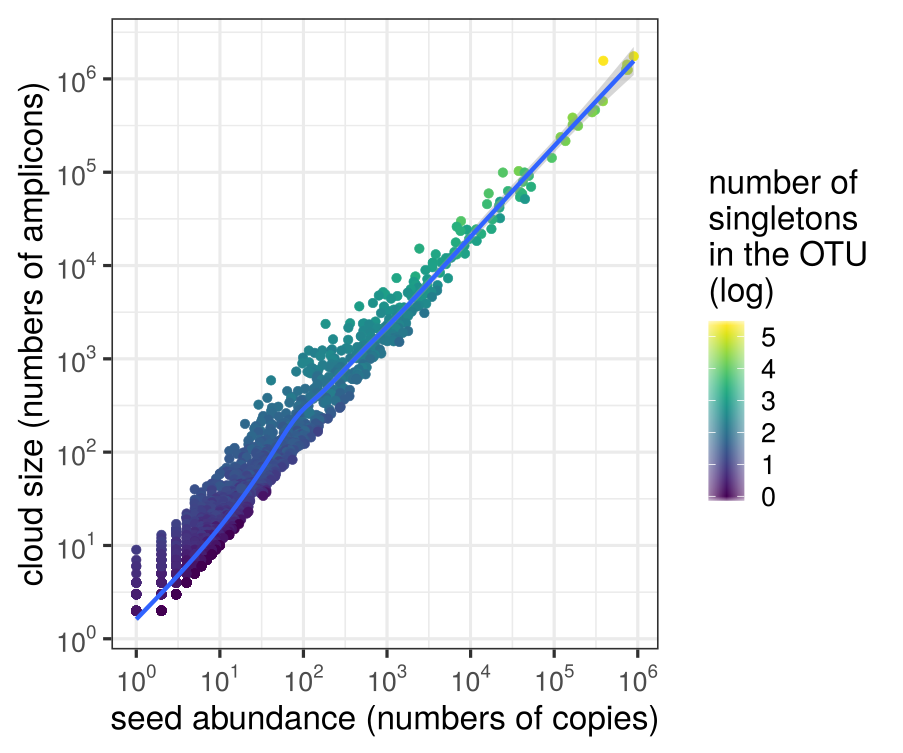
<!-- .element height="50%" width="50%" -->

### post-super OTU breaking

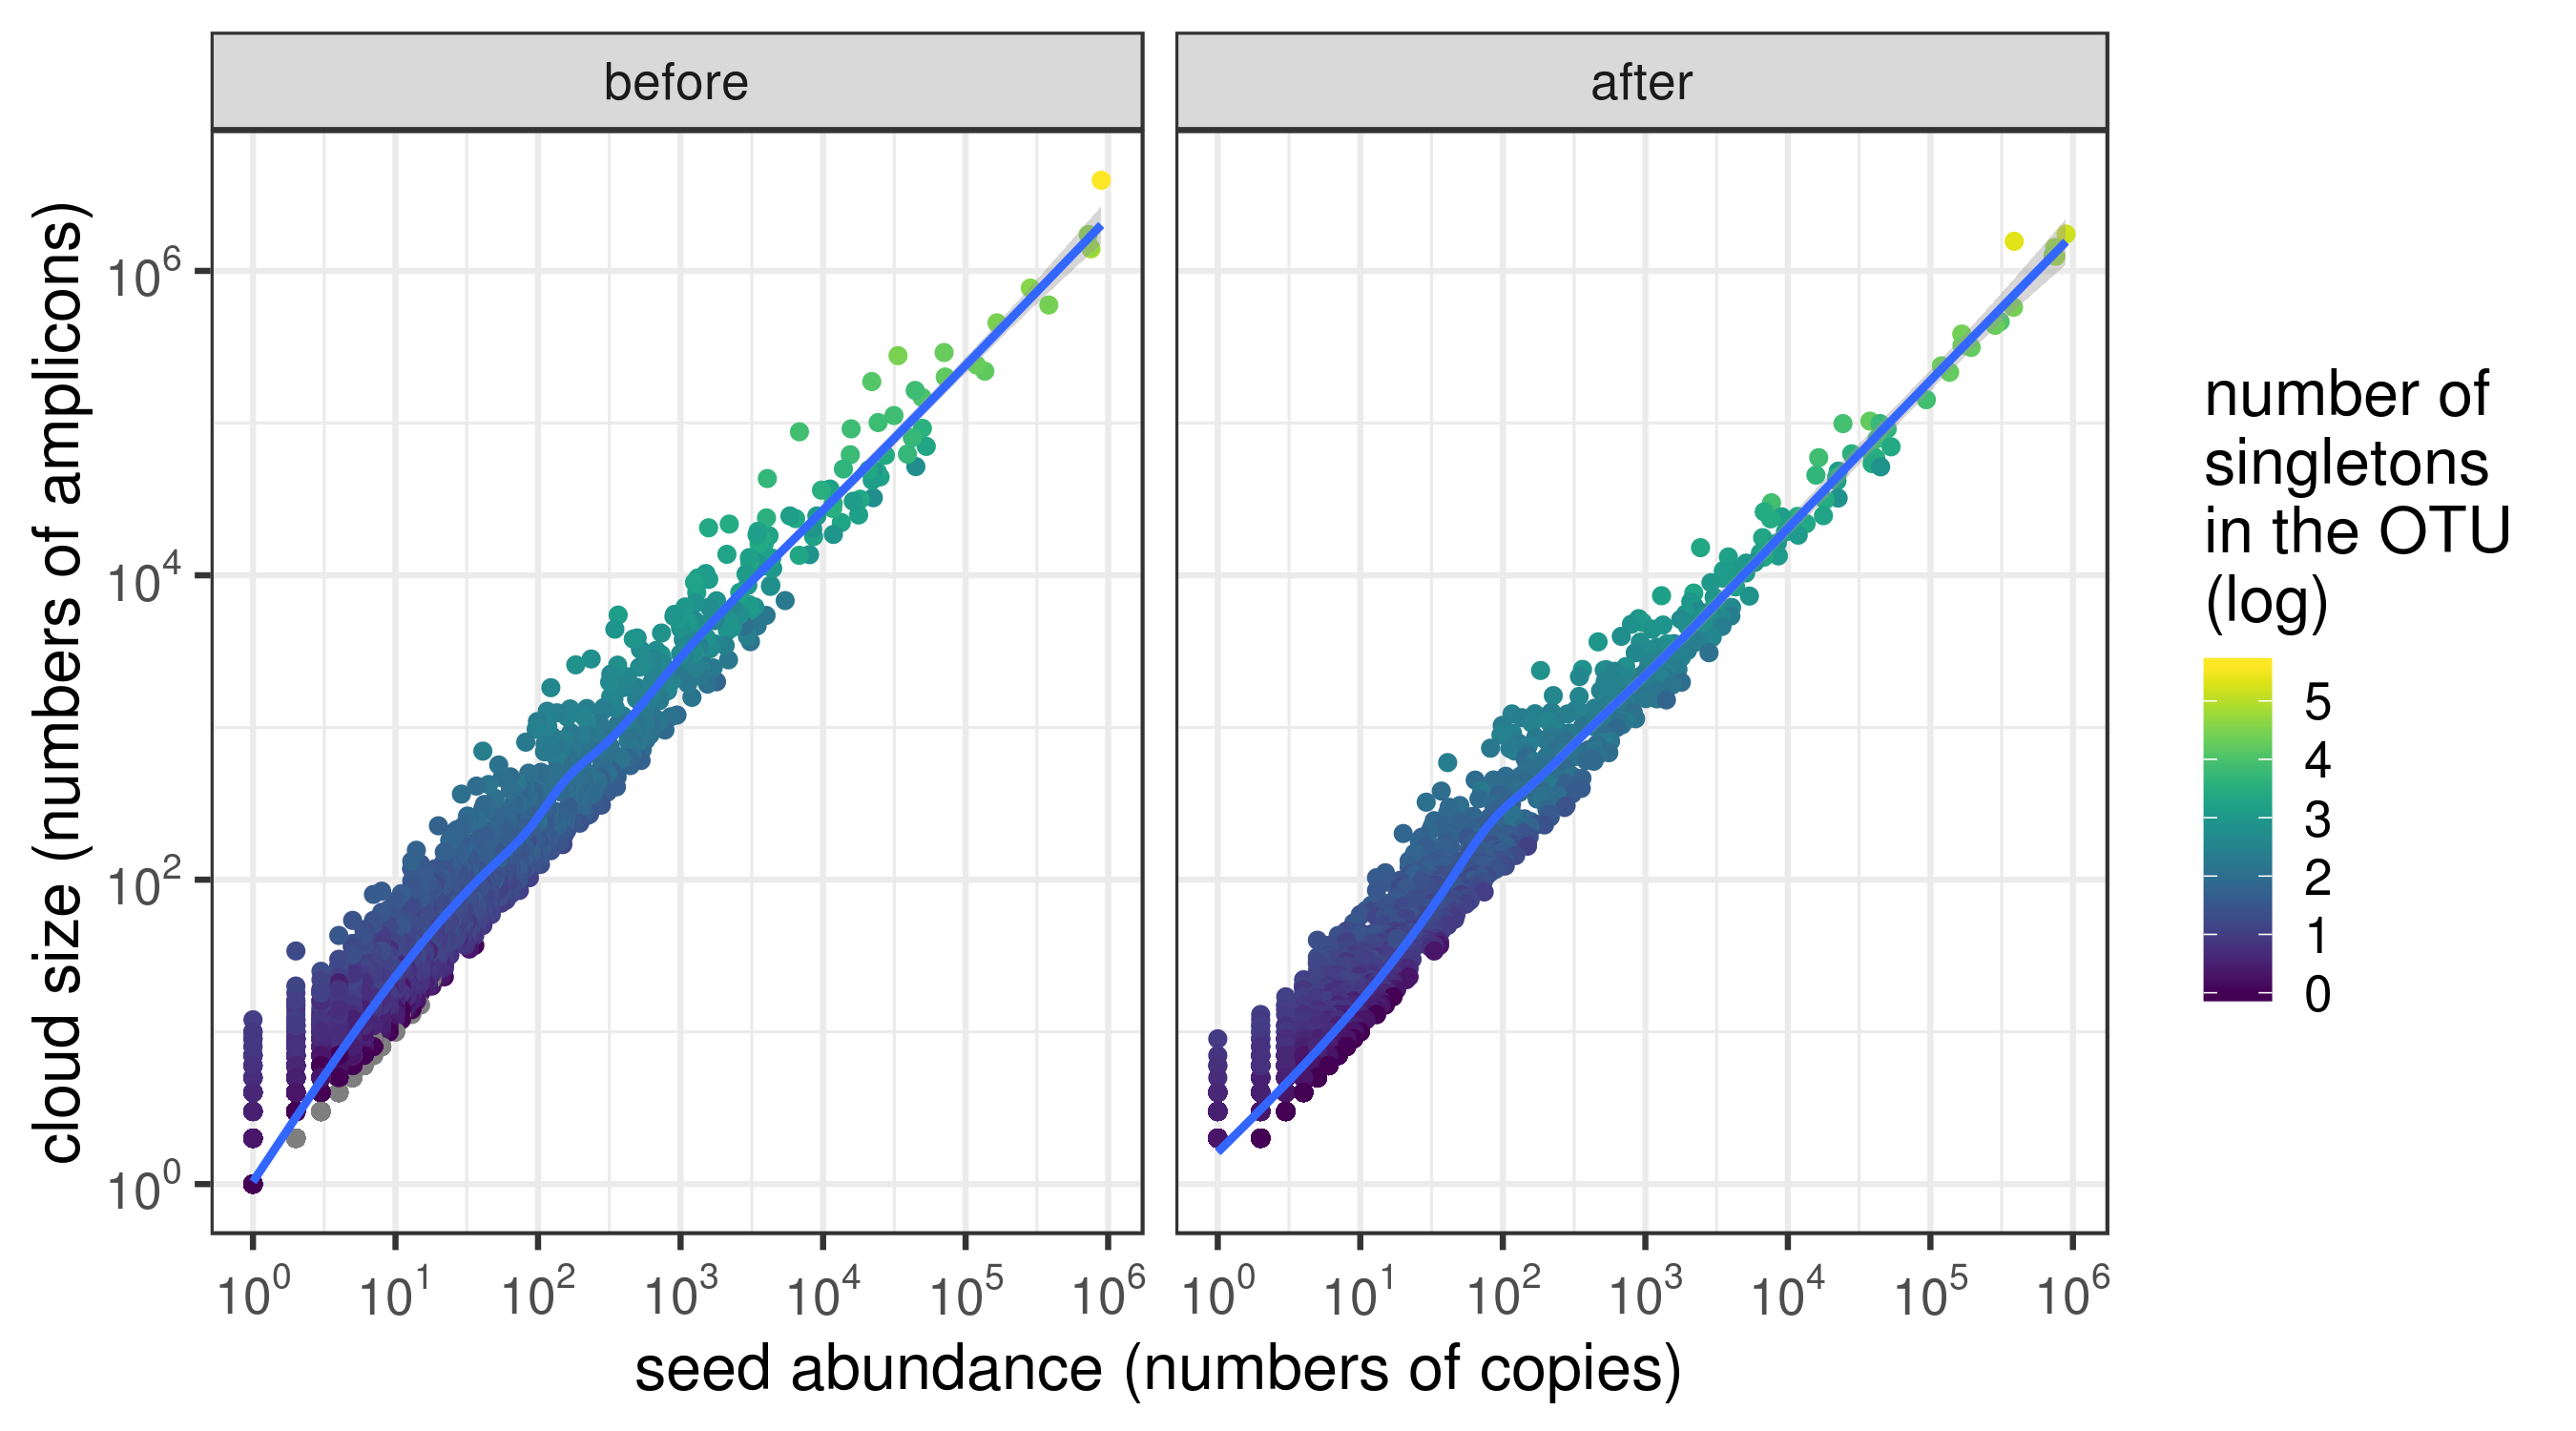